# DC Language Immersion: Mapping Addresses to Feeder Schools 

<img src="https://i0.wp.com/dcimmersion.org/wp-content/uploads/2016/04/cropped-dcimmersion_linkedin_logo_b.png?fit=512%2C512" style="float:right; height: 50px; width: 50px; padding: 0em 1em 0em 1em;"></img>



---
**Author** Glenn Abastillas | **Created** April, 14, 2019 | **Category** Volunteer Work | Language Not-for-Profit

This notebook shows how to assign addresses to school districts in an automated way. The address information comes from the DC Language Immersion Google Drive storage. The school district and ward data comes from the [DC Government's Open Data](www.opendata.dc.gov) APIs.

Update:
    1. July 10, 2019: received data from DC Language Immersion to test boundary school and ward assignment.

---
#### Import Packages

In [174]:
import pandas as pd
import geopandas as gpd
import shapely as shp
import shapefile
import usaddress
import re

from geopy.geocoders import Nominatim
from random import randint

%matplotlib inline

#### Load Map Data

Define the path and label variables.

In [175]:
folder = "../"
prefix = 'School_Attendance_Zones'
levels = ['Elementary', 'Middle_School', 'Senior_High']

Point data files.

In [176]:
data = {levels[i]: pd.read_csv(f"{folder}/{prefix}_{levels[i]}.csv") for i in range(3)}

In [177]:
data['Elementary'].sample(2)

,OBJECTID,NAME,Shape_Length,Shape_Area,GIS_ID
29,30,Houston,5114.179224,1.216817e+06,dcps_251
8,9,Brent,4589.649889,1.143600e+06,dcps_212


Load the Shape files.

In [178]:
shapes = {levels[i]: shapefile.Reader(f"{folder}/{prefix}_{levels[i]}/{prefix}_{levels[i]}.shp") for i in range(3)}

In [190]:
shapes[levels[0]]

Shape methods include `bbox`, `parts`, `points`, `shapeType`, `shapeTypeName`.

Coordinate information is contained in the `points` attribute. The following cell prints out a random district shape every time it is run.

In [179]:
# import random
# READER = shapes[levels[0]]

School boundary #2


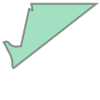

In [180]:
# Set some parameters
level = 'Elementary'
LOW, HI = 0, len(shapes[level].shapes())

# Sample a shape
random_integer = randint(LOW, HI)
example_shape = shp.geometry.Polygon(shapes[level].shape(random_integer).points)
print(f"School boundary #{random_integer}")
example_shape

#### Instantiate Geocoders to Convert Addresses

Instantiate the Geocoder and use it to convert addresses into `Point` objects to allow for inclusion checking.

In [181]:
geocoder = Nominatim(user_agent="default")

Load contact data and information.

In [182]:
raw_contacts = pd.read_csv("dc_language_immersion_contacts.csv").drop_duplicates()
raw_contacts.columns

Index(['First Name', 'Last Name', 'Organization', 'Title in Organization',
       'EMAIL', 'CAREGIVER', 'EDUCATOR', 'PRESS', 'GOVERNMENT',
       'LANGUAGE INDUSTRY', 'COMMUNITY PARTNER', 'STUDENT', 'TYPE',
       'School(s) your child(ren) attend',
       'Why do you care about language immersion?', 'panel attended',
       'Street Address 1', 'Work', 'Cell', 'Other', 'City', 'State',
       'Zip Code', 'How many children do you have?',
       'What is your ward of residence?', 'Languages spoken',
       'How did you hear about this event?', 'Type of resource', 'Website',
       'NOTES', 'DC Immersion', 'DC DL Network', 'Elected Officials and staff',
       'Events invited to', 'MEMBER_RATING', 'OPTIN_TIME', 'CONFIRM_TIME',
       'LATITUDE', 'LONGITUDE', 'GMTOFF', 'DSTOFF', 'TIMEZONE', 'CC', 'REGION',
       'LAST_CHANGED', 'LEID', 'EUID', 'In-Boundary School',
       'Text Opt In Status', 'P2A Email Action', 'P2A Faceook Action',
       'P2A Phone Action', 'P2A Twitter Action',
    

In [183]:
# Check if EUID and LEID are actually unique identifiers
(raw_contacts.EUID.unique().shape[0] == raw_contacts.LEID.unique().shape[0] == raw_contacts.shape[0])

True

In [184]:
raw_contacts.TYPE = raw_contacts.TYPE.apply(lambda x: '; '.join([__.title() for __ in x.split(';') if __.strip()]))

contacts = raw_contacts[raw_contacts['Street Address 1'].notnull()]
contacts = contacts[['EUID', 'LEID', 'Street Address 1', 'City', 'State', 'Zip Code']]
contacts.columns = ['euid', 'leid', 'address', 'city', 'state', 'zip']
contacts.shape

(877, 6)

Some contacts' addresses have a DC street address, but out of state city and state designation. These functions help analyze the street address.

In [18]:
def n_tokens(addr):
    return(len(addr.split()))

def valid_quadrant(addr):
    suffix = addr.split()[-1].upper()
    if(suffix not in ['NW', 'NE', 'SE', 'SW']):
        return(False)
    return(True)

In [84]:
valid_quadrant_ = contacts.address.apply(valid_quadrant)
not_washington_ = ~contacts.city.apply(lambda x: 'ashi' in str(x).lower())
state_is_in_dc_ = contacts.state.str.lower() == 'dc'
state_is_an_nan = contacts.state.isnull()

contacts[valid_quadrant_ & not_washington_ & (state_is_in_dc_ | state_is_an_nan)]

,euid,leid,address,city,state,zip


Replace `NaN` city names with Washington if the address is in Washington, DC. Assume that street addresses with quadrant information are in DC.

In [85]:
# contacts.loc[contacts[valid_quadrant_ & not_washington_ & (state_is_in_dc_ | state_is_an_nan)], 'city'] = 'Washington'
# contacts.loc[contacts[valid_quadrant_ & not_washington_ & (state_is_in_dc_ | state_is_an_nan)], 'state'] = 'DC'
contacts.loc[valid_quadrant_ & not_washington_ & (state_is_in_dc_ | state_is_an_nan), 'city'] = 'Washington'
contacts.loc[valid_quadrant_ & (state_is_an_nan), 'state'] = 'DC'

In [86]:
contacts.loc[state_is_in_dc_, 'city'] = 'Washington'

Save this second dataset, which contains rows of contacts with a `state=='dc'`

In [87]:
# df2 = contacts.copy()
# df2.to_csv("contacts_washington_dc.csv", index=False)

In [88]:
contacts[state_is_in_dc_].city.unique()

array(['Washington'], dtype=object)

#### Address Analysis

Discover different address types for regular expression normalization. All entries had a `state='DC'`.

In [89]:
contacts.address.unique()[:5]

array(['6100 nebraska ave nw', 'Po box 2194', '8000 Blair Mill Drive',
       '15505 Bounds Ave.', '22 Hesketh Street'], dtype=object)

In [90]:
dc = contacts[state_is_in_dc_]
dc.shape

(494, 6)

#### ZIP
Examine the ZIP codes for all DC rows.

In [91]:
dc.zip.unique()

array([nan, '20016', '20020', '20024', '20005', '20004', '20009', '20011',
       '20019', '20045', '20001', '20006', '20036', '20010', '20017',
       '20008', '20012', '20002', '20018', '20003', '20064', '20032',
       '20772', '20040', '20015', '20853', '22204', '20013', '22311',
       '20019-3802', '20912', '20903', '20037', '20007', '20910', '20090',
       '21061', '20021'], dtype=object)

#### City
Examine the city names for all DC rows.

In [92]:
washington = ('Washington', re.compile(r"\w+?shingt\w+?|DC|Wa", re.IGNORECASE))
dc[dc.city.apply(lambda x: len(washington[1].findall(str(x))) > 0)].city.unique()

array(['Washington'], dtype=object)

Define a function to get just the `StreetPostType` data from the street addresses.

In [111]:
def get_address_type(street_address):
    try:
        return(usaddress.tag(street_address)[-1])
    except:
        return(None)
    

In [116]:
dc.loc[:,'address_type'] = dc.address.apply(get_address_type)
dc.address_type.value_counts()

/Users/glenabastillas/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Street Address    478
Ambiguous           9
PO Box              4
Name: address_type, dtype: int64

##### Quadrant

Check if the street address ends in a quadrant. Separate addresses into two variables.

In [97]:
dc_valid_quadrant = dc[dc.address.apply(valid_quadrant) & dc.city.isin([washington[0]])]
dc_valid_quadrant.shape

(396, 6)

In [98]:
dc_invalid_quadrant = dc[~dc.address.apply(valid_quadrant) & dc.city.isin([washington[0]])]
dc_invalid_quadrant.shape

(98, 6)

Some examples of tokens that end a street address.

In [99]:
dc_invalid_quadrant[dc_invalid_quadrant.address.apply(n_tokens) > 1].address.apply(lambda x: x.split()[-2]).sort_values().unique()

array(['#', '-', '1', '1615', '3rd', '4514', '4th', '9th', 'A', 'APT',
       'Aprt', 'Apt', 'Apt.', 'Ave', 'Belmont', 'Bison', 'Box', 'C',
       'Calvert', 'Cathedral', 'Columbia', 'Connecticut', 'D.C', 'DC',
       'Dakota', 'Douglas', 'F', 'G', 'Hampshire', 'Manor',
       'Massachussets', 'Mercury', 'Mintwood', 'NE', 'NE,', 'NW', 'NW,',
       'Oakview', 'Osborn', 'Place', 'Pomeroy', 'Quebec', 'Rd.', 'SE',
       'SE,', 'Suite', 'Unit', 'Virginia', 'Vista', 'York', 'apt', 'box',
       'columbia', 'dc', 'florida', 'harvard', 'l', 'nw', 'sports'],
      dtype=object)

The next cell investigates the type of suffixes for the valid quadrant data for regular expression development.

In [101]:
dc_valid_quadrant[dc_valid_quadrant.address.apply(n_tokens) > 1].address.apply(lambda x: x.split()[-2]).sort_values().unique()

array(['Alley', 'Av.', 'Ave', 'Ave,', 'Ave.', 'Avenue', 'Avenue,',
       'Branch', 'CT', 'Ct', 'Dr', 'Dr.', 'Ln', 'PL', 'PL,', 'Pl',
       'Place', 'Place,', 'Rd', 'Rd,', 'Road', 'ST', 'ST.', 'STREET',
       'St', 'St.', 'St.,', 'Street', 'Street,', 'Waltman', 'Way', 'ave',
       'dr', 'dr.', 'pl', 'place', 'road', 'st', 'st.', 'street',
       'street,', 'way'], dtype=object)

##### Regular Expressions for Normalizing Addresses
Regular expressions can be used to standardize the address names. First create a shorthand variable name for the two types of quadrant classifications.

In [36]:
dcv = dc_valid_quadrant
dci = dc_invalid_quadrant

Now create the regular expressions to detect the street entities and the replacement term. These post types were determined by examining the data.

In [122]:
import re

types = [('alley',          r'all?e?y'), 
         ('avenue',         r'av(\w+)?\S?'), 
         ('boulevard',     r'b\w{0,2}l\w?v\w?r?d'),
         ('branch',         r'branch\S?'), 
         ('court',          r'c[ou]{0,2}r?t\S?'), 
         ('drive',          r'dr(ive)?\S?'), 
         ('lane',           r'l\w?n\w?\S?'), 
         ('place',          r'pl(ace)?\S?'), 
         ('road',           r'r[oa]{0,2}d\S?'), 
         ('street',         r'st(ree?t)?\S?'), 
         ('way',            r'wa?y')]

types_dict = dict([(a, re.compile(b, re.IGNORECASE)) for a, b in types])

Test the regular expressions on an example.

In [123]:
# example = ' 2342 Nebraska av.'
# [types_dict[key].sub(key, example) for key in types_dict.keys()]

Define functions to normalize street address strings.

In [124]:
types_dict['street'].sub('street', 'testing this st.')

'testreetng this street'

In [125]:
def get_address_type(A):
    """ See if input address `A` is a Street Address, PO Box, Ambiguous, or None """
    try:
        return(usaddress.tag(A)[-1])
    except:
        return(None)

def normalize_posttype(P, tdict=types_dict):
    for key in tdict:
        regex = tdict[key]
        if(regex.findall(P)):
            return(regex.sub(key, P))
    return(P)

def normalize_address(A):
    try:
        parsed, street_type = usaddress.tag(A)
        A = parsed['AddressNumber'].replace('.', '')
        B = parsed['StreetName'].replace('.', '')
        
        # Process StreetNames if numeric
        B = B.lower() if B[0].isdigit() else B.title()
        B = f"{B}th" if (B.isdigit()) else (f"{B[:-2]}th" if (B[:-2].isdigit()) else B)
        B = f"{B[:-2]}st" if B[:-2].isdigit() and (B[:-2] == '1' or B[-3] == '1') else B
        B = f"{B[:-2]}nd" if B[:-2].isdigit() and (B[:-2] == '2' or B[-3] == '2' and B[0] != '1') else B
        
        C = normalize_posttype(parsed['StreetNamePostType']).title()
            
        try:
            D = parsed['StreetNamePostDirectional'].upper()
        except:
            D = 'NW'
        return(f"{A} {B} {C} {D}".replace('.', ''))
        
    except:
#         print(A)
        return(None)

Normalize the addresses of the original dataset `contacts`.

In [126]:
contacts = contacts.assign(address_type=contacts.address.apply(get_address_type))
contacts.address_type.value_counts()

Street Address    840
Ambiguous          22
PO Box              9
Name: address_type, dtype: int64

In [127]:
contacts.loc[contacts.address_type.isin(['Street Address']),].assign(address_norm=contacts.address.apply(normalize_address)).sample(10)

,euid,leid,address,city,state,zip,address_type,address_norm
602,c8af6d7e5a,587253041.0,3133 Connecticut Ave NW,Washington,DC,20008,Street Address,3133 Connecticut Avenue NW
1982,db1544ee94,581753621.0,2921 W St SE,Washington,DC,20020,Street Address,2921 W Street SE
610,7d77d939f7,587253085.0,2016 basil hall court,Gambrills,MD,21054,Street Address,2016 Basil Hall Court NW
1879,7f05d90387,587253853.0,1701 N Kent St,Arlington,VA,22209,Street Address,1701 Kent Street NW
1841,7a203c590b,584716629.0,2000 M St. NW,Washington,DC,NaN,Street Address,2000 M Street NW
914,175ebe60b6,587254629.0,301 G Street SW,Washington,DC,20024,Street Address,301 G Street SW
2132,885ef43b5e,587253729.0,209 N. Trenton St. #4,Arlington,VA,22203,Street Address,209 Trenton Street NW
815,22d1bb1a93,587255041.0,7140 Royal Fern Circle Apt 203,Manassas,VA,20111,Street Address,7140 Royal Fern Circle NW
1800,14eaeb1bb8,587253685.0,4201 wilson blvd,Arlington,VA,22203,Street Address,4201 Wilson Boulevard NW
1185,89da479f8a,233975861.0,3123 Queens Chapel Rd,Mount Rainier,MD,20712,Street Address,3123 Queens Chapel Road NW


In [136]:
dc = contacts[state_is_in_dc_ & (contacts.address_type == 'Street Address')]
not_dc = contacts[~state_is_in_dc_ & (contacts.address_type == 'Street Address')]
dc.shape

(478, 7)

### Assign Dataset to `current`

Assign which dataset to focus on with the `current` variable.

In [138]:
current = dc

Continue to process the street addresses.

In [139]:
current_st = current[current.address_type.isin(['Street Address'])]

print(current_st.shape)
current_st.address.sample(10).apply(normalize_address)

(478, 7)


1191             1101 L Street NW
1466            6439 2nd Place NW
285     920 Westminster Street NW
629          2872 Perry Street NE
2288             2517 K Street NW
883            1100 1st Street SE
1165          1813 13th Street NW
1517           1904 3th Street NW
711            1413 Ives Place SE
527         2142 Branch Avenue SE
Name: address, dtype: object

In [140]:
current_st = current_st.assign(address_clean=current_st.address.apply(normalize_address))

In [147]:
# address = "1160 1st Street NE, Washington DC 20002"
address = ', '.join(current_st.sample()[['address_clean', 'city', 'state', 'zip']].iloc[0])
location = geocoder.geocode(address)
print(address)

1600 New York Avenue NW, Washington, DC, 20003


Get the location point coordinates and check for inclusion.

In [148]:
location_point = shp.geometry.Point(tuple(location.point))
example_shape.contains(location_point)

False

#### Tester to Find School District for Address

First design the logic then create the function definition.

Your Senior_High school for 1600 New York Avenue NW, Washington, DC, 20003 is 1.


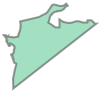

In [149]:
level = levels[2]
SIZE = 0, len(shapes[level].shapes())

for i in range(len(SIZE)):
    current = shp.geometry.Polygon(shapes[level].shape(i).points)
    if(current.contains(location_point)):
        break

# shape = shapes[level].shape(i)        
print(f"Your {level} school for {address} is {i}.")
current

In [150]:
location

Location(New York Avenue Northwest, Chinatown, Washington, D.C., 20401, USA, (38.905814, -77.0136501, 0.0))

In [151]:
from shapely.geometry import Point, Polygon
    
def assign_school_zone(address, school_data=data, shape_data=shapes, school_levels=levels, level=0):
    """ Return school name and object ID. """
    if(address):
        longitude, latitude, altitude = tuple(geocoder.geocode(address).point)

        point = Point((latitude, longitude))
        school = school_levels[level] if isinstance(level, int) else level

        for i, shape in enumerate(shape_data[school].shapes()):
            polygon = Polygon(shape.points)
            if(polygon.contains(point)):
                return(i+1, f"{school_data[school].loc[i,'NAME']} {school}")
    return(None)

### Deploy School Zone Assignment Algorithm

Test the algorithm on a single address and then multiple addresses.

In [152]:
assign_school_zone(address, data, shapes, levels, 'Middle_School')

(1, 'Walker-Jones Middle_School')

Test multiple addresses

In [115]:
list(current_st[['address', 'city', 'state', 'zip']].iterrows())[0]

(41, address    1101 4th ST SW Suite W772
 city                      Washington
 state                             DC
 zip                            20024
 Name: 41, dtype: object)

In [154]:
from tqdm import tqdm
# addresses = ['1150 1st street ne', '1822 1st St NW, Washington, DC 20001', '1918 14th St SE, Washington, DC 20020']

DATA = current_st
decide = lambda x: x if x else ''
addresses = [(f"{decide(a)} {decide(b)} {decide(c)} {decide(d)}".strip(), e, f) 
             for i, (a, b, c, d, e, f) in list(DATA[['address_clean', 'city', 'state', 'zip', 'euid', 'leid']].iterrows())]

address_boundary = list()

for address, euid, leid in tqdm(addresses):
    boundary = list()
    for level in levels:
        try:
            school = f"{assign_school_zone(address, level=level)[1].replace('_', '')}"
            boundary.append(school)
        except:
#             print(f"Errant address {address}")
            break
    address_boundary.append(tuple([euid, leid, address] + boundary))

len(address_boundary)

100%|██████████| 478/478 [12:46<00:00,  1.46s/it]


478

Address and boundary schools from the `dci` (`dc_invalid_quadrant`) data set.

In [117]:
# ab_dci = address_boundary # Comment out once assigned to allow the list above to get reassigned
len(ab_dci)

78

Address and boundary schools from the `dcv` (`dc_valid_quadrant`) data set.

In [103]:
# ab_dcv = address_boundary # Comment out once assigned to allow the list above to get reassigned
len(ab_dcv)

360

Create a new DataFrame to hold processed data.

In [160]:
processed = pd.DataFrame(address_boundary, columns=['euid', 'leid', 'address', 'elementary_school', 'middle_school', 'senior_school'])
processed.shape

(478, 6)

Number of addresses where there is no boundary school information available at all for the addresses.

In [161]:
processed[processed.senior_school.isnull() & processed.middle_school.isnull() & processed.elementary_school.isnull()].shape

(94, 6)

Look into the address where there is a school available.

In [162]:
processed[~processed.senior_school.isnull() & ~processed.middle_school.isnull() & ~processed.elementary_school.isnull()].sample(10)

,euid,leid,address,elementary_school,middle_school,senior_school
391,813d92fcd3,587253497.0,834 5th Street NE Washington DC 20002,"Wilson, J.O. Elementary",Stuart-Hobson MiddleSchool,Eastern SeniorHigh
34,776aa6b75d,234071337.0,1816 Vermont Avenue NW Washington DC 20001,Garrison Elementary,Shaw MiddleSchool,Cardozo SeniorHigh
335,2970928743,581753613.0,1524 34th Street NW Washington DC 20007,Hyde-Addison Elementary,Hardy MiddleSchool,Wilson SeniorHigh
323,d21f2ebefb,581753421.0,1234 Quincy Street NE Washington DC 20017,Brookland @ Bunker Hill Elementary,Brookland MiddleSchool,Dunbar SeniorHigh
120,e13a610e98,587254109.0,800 Florida Avenue NE Washington DC 20002,Wheatley Elementary,Wheatley MiddleSchool,Dunbar SeniorHigh
178,0e47507dfe,587252813.0,303 Seaton Place NW Washington DC 20002,Langley Elementary,McKinley MiddleSchool,Dunbar SeniorHigh
225,2c29c710c9,581753369.0,1813 13th Street NW Washington DC 20009,Garrison Elementary,Shaw MiddleSchool,Cardozo SeniorHigh
168,15bcb10d52,587252825.0,2202 18th Street NW Washington DC 20009,Oyster-Adams Elementary,Oyster-Adams MiddleSchool,Wilson SeniorHigh
172,89547e361f,587254769.0,1215 First Street NE Washington DC 20002,Walker-Jones Elementary,Walker-Jones MiddleSchool,Dunbar SeniorHigh
198,bae7b09add,581753629.0,4204 38th Street NW Washington DC 20016,Hearst Elementary,Deal MiddleSchool,Wilson SeniorHigh


Save current processed DataFrame.

In [163]:
processed.to_csv("./processed.csv", index=False)

#### Merge Back to Original Data

Using the street address, city, and state columns, merged cleaned and assigned data back to main dataset. First, separate out the street address.

In [164]:
processed = processed.assign(street_address=processed.address.apply(lambda x: ' '.join(x.split()[:-3])))
processed.head()

,euid,leid,address,elementary_school,middle_school,senior_school,street_address
0,54ca72b5b7,581755493.0,3722 Hansberry Court NE Washington DC nan,Langdon Elementary,McKinley MiddleSchool,Dunbar SeniorHigh,3722 Hansberry Court NE
1,4da6a57e31,581755361.0,1704 Massachusetts Avenue SE Washington DC nan,None,None,None,1704 Massachusetts Avenue SE
2,29e799a000,289867661.0,4317 Yuma Street NW Washington DC 20016,None,None,None,4317 Yuma Street NW
3,d216f60a89,585976581.0,2101 Martin Luther King Jr Avenue SE Washingto...,None,None,None,2101 Martin Luther King Jr Avenue SE
4,fb091d4e03,582728597.0,1101 4th Street SW Washington DC 20024,Amidon-Bowen Elementary,Jefferson MiddleSchool,None,1101 4th Street SW


Now, attempt to merge the datasets.

In [168]:
merged = contacts.merge(processed, on=['euid', 'leid'])
merged.head()

,euid,leid,address_x,city,state,zip,address_y,elementary_school,middle_school,senior_school,street_address
0,54ca72b5b7,581755493.0,3722 Hansberry CT NE,NaN,DC,NaN,3722 Hansberry Court NE Washington DC nan,Langdon Elementary,McKinley MiddleSchool,Dunbar SeniorHigh,3722 Hansberry Court NE
1,4da6a57e31,581755361.0,1704 Massachusetts Avenue SE,NaN,NaN,NaN,1704 Massachusetts Avenue SE Washington DC nan,None,None,None,1704 Massachusetts Avenue SE
2,29e799a000,289867661.0,4317 Yuma St NW,Washington,DC,20016,4317 Yuma Street NW Washington DC 20016,None,None,None,4317 Yuma Street NW
3,d216f60a89,585976581.0,2101 Martin Luther King Jr. Ave SE,NaN,NaN,20020,2101 Martin Luther King Jr Avenue SE Washingto...,None,None,None,2101 Martin Luther King Jr Avenue SE
4,fb091d4e03,582728597.0,1101 4th ST SW Suite W772,Washington,DC,20024,1101 4th Street SW Washington DC 20024,Amidon-Bowen Elementary,Jefferson MiddleSchool,None,1101 4th Street SW


In [166]:
merged.shape

(478, 10)

In [167]:
merged.to_csv("./merged_1.csv", index=False)

#### Connecting via API

Sandbox for reading in School Attendance Zones for Senior High School from the Open Data repository.

In [185]:
api_data = gpd.read_file("https://opendata.arcgis.com/datasets/d2e0486155144b6d8e11e12469a64b1c_15.geojson")
api_data.head(2)

,OBJECTID,NAME,Shape_Length,Shape_Area,GIS_ID,geometry
0,1,Anacostia,19915.536943,1.537354e+07,dcps_450,(POLYGON ((-76.95593778860624 38.8897877783330...
1,2,Ballou,32540.554149,2.476491e+07,dcps_452,POLYGON ((-76.98867727860566 38.86848178109721...


In [186]:
geometry = api_data['geometry']

In [187]:
geometry.head()

0    (POLYGON ((-76.95593778860624 38.8897877783330...
1    POLYGON ((-76.98867727860566 38.86848178109721...
2    (POLYGON ((-77.04278529845381 38.927686791488,...
3    POLYGON ((-77.01459660600285 38.97535907024628...
4    (POLYGON ((-77.00465721552102 38.9516404465242...
Name: geometry, dtype: object

In [188]:
shape1 = Polygon(geometry[1])

ImportError: The descartes package is required for plotting polygons in geopandas.

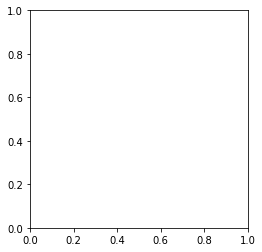

In [189]:
api_data.plot(label='NAME')

In [ ]:
geojson_copy = "https://opendata.arcgis.com/datasets/d2e0486155144b6d8e11e12469a64b1c_15.geojson"

---

# END